In [37]:
# EDA on filtered protacs
import numpy as np
import pandas as pd
import math

df = pd.read_csv("filtered_protacs.csv")
f = open("dc50_labels.txt", "r")
lines = f.readlines()
refined_lines = []
for l in lines:
    l = l.replace("(n/a)", "")
    l = l.replace("\n", "")
    l = l.replace(">", "")
    l = l.replace("<", "")
    l = l.replace("=", "")
    refined_lines.append(l)
print(len(refined_lines))

final_labels = []
for l in refined_lines:
    arr = l.split('/')
    if len(arr) > 1:
        smallest_so_far = 999999
        for el in arr:
            if el == "":
                continue
            if el.find("~") > 0 or el.find("-") > 0:
                continue
            el = float(el)
            if el < smallest_so_far:
                smallest_so_far = el
        final_labels.append(smallest_so_far)
    else:
        final_labels.append(arr[0])
print(len(final_labels))
target_proteins = np.array(list(df["Target Protein"]))
print(len(target_proteins))
e3_targets = np.array(list(df["E3 Target"]))
warheads = np.array(list(df["Warhead"]))
linkers = np.array(list(df["Linker"]))
e3_ligands = np.array(list(df["E3 Ligand"]))
dc_50 = np.array(list(df["DC50 (nM)"]))

labeled_indices = []
for i, val in enumerate(final_labels):
    val = str (val)
    if val == "":
        continue
    else:
        labeled_indices.append(i)

target_proteins = target_proteins[labeled_indices]
e3_targets = e3_targets[labeled_indices]
warheads = warheads[labeled_indices]
linkers = linkers[labeled_indices]
e3_ligands = e3_ligands[labeled_indices]
final_labels = np.array(final_labels)
my_labels = final_labels[labeled_indices]

print(len(target_proteins))
print(len(set(e3_targets)))
print(len(warheads))
print(len(linkers))
print(len(e3_ligands))
print(len(my_labels))


5388
5388
5388
905
7
905
905
905
905


In [38]:
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product

def get_fingerprint(smiles, r=3, nBits=1024):
    compound = Chem.MolFromSmiles(smiles.strip())
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits=nBits)
    m = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint,m)
    return m


def sequence_to_kmer(protein_seq, k):
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range(0, len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range(0, len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct, ind))
    
    V=np.zeros(int((math.pow(7,k))))
    try:
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]] += 1
    except:
        count={'1':0,'2':0,'3':0, '4':0, '5':0,'6':0,'7':0}
        for q in range(0,len(protein_seq)):
            if protein_seq[q]=='A' or protein_seq[q]=='V' or protein_seq[q]=='G':
                count['1']+=1
            if protein_seq[q]=='I' or protein_seq[q]=='L'or protein_seq[q]=='F' or protein_seq[q]=='P':
                count['2']+=1
            if protein_seq[q]=='Y' or protein_seq[q]=='M'or protein_seq[q]=='T' or protein_seq[q]=='S':
                count['3']+=1
            if protein_seq[q]=='H' or protein_seq[q]=='N'or protein_seq[q]=='Q' or protein_seq[q]=='W':
                count['4']+=1
            if protein_seq[q]=='R' or protein_seq[q]=='K':
                count['5']+=1
            if protein_seq[q]=='D' or protein_seq[q]=='E':
                count['6']+=1
            if protein_seq[q]=='C':
                count['7']+=1
        
        value=list(count.values())
        key=list(count.keys())
        maximum_occurence=0
        index=0
        for t in range(0, len(value)):
            if maximum_occurence < value[t]:
                maximum_occurence = value[t]
                index=t
        maximum_occurence = key[index] # group number of maximum occuring group
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                if kmer[l] not in groups:
                    c += maximum_occurence
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]] += 1
            
        V = V/(len(protein_seq)-1)
        return np.array(V)
    

def get_protein_features(protein_sequence):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f = []
    protein_info = ProteinAnalysis(str(protein_sequence))
    protein_info.molecular_weight()
    amino_acid_percent = protein_info.get_amino_acids_percent()
    dp = []
    for a in aa:
        dp.append(amino_acid_percent[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    twomer=np.array(sequence_to_kmer(str(protein_sequence), 2))
    twomer=normalize(np.atleast_2d(twomer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(twomer[0])
    threemer=np.array(sequence_to_kmer(str(protein_sequence), 3))
    threemer=normalize(np.atleast_2d(threemer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(threemer[0])
    return np.array(f)

In [39]:
labels = []
for m in my_labels:
    if m.find("~") > 0:
        m.split("~")
        m = float (m[0])
        labels.append(m)
    elif m.find("-") > 0:
        m.split("-")
        m = float (m[0])
        labels.append(m)
    else:
        m = float (m)
        labels.append(m)
        

target_protein_features = []
e3_target_features = []
warhead_fingerprints = []
e3_lignad_fingerprints = []
linker_fingerprints = []
for i in tqdm(range(len(target_proteins))):
    p = get_protein_features(target_proteins[i])
    et = get_protein_features(e3_targets[i])
    
    w = get_fingerprint(warheads[i])
    if linkers[i] == "nan":
        l = np.zeros(1024)
    else:
        l = get_fingerprint(linkers[i])
    
    if "[R2]" in e3_ligands[i]:
        e = e3_ligands[i].replace("[R2]", "")
        el = get_fingerprint(e)
    else:
        el = get_fingerprint(e3_ligands[i])
        
    target_protein_features.append(p)
    e3_target_features.append(et)
    warhead_fingerprints.append(w)
    e3_lignad_fingerprints.append(el)
    linker_fingerprints.append(l)
    
target_protein_features = np.array(target_protein_features)
e3_target_features = np.array(e3_target_features)
warhead_fingerprints = np.array(warhead_fingerprints)
e3_lignad_fingerprints = np.array(e3_lignad_fingerprints)
linker_fingerprints = np.array(linker_fingerprints)

print(target_protein_features.shape)
print(e3_target_features.shape)
print(warhead_fingerprints.shape)
print(e3_lignad_fingerprints.shape)
print(linker_fingerprints.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [00:20<00:00, 44.59it/s]

(905, 412)
(905, 412)
(905, 1024)
(905, 1024)
(905, 1024)


In [40]:
dataset = np.column_stack((target_protein_features, e3_target_features,
                           warhead_fingerprints, e3_lignad_fingerprints, linker_fingerprints))

print(dataset.shape)
print(dataset[0])
labels = np.array(labels)
labels = np.log(labels)
print(labels.shape)

(905, 3896)
[0.24031511 0.09477216 0.27077759 ... 0.         0.         0.        ]
(905,)


(905, 2)


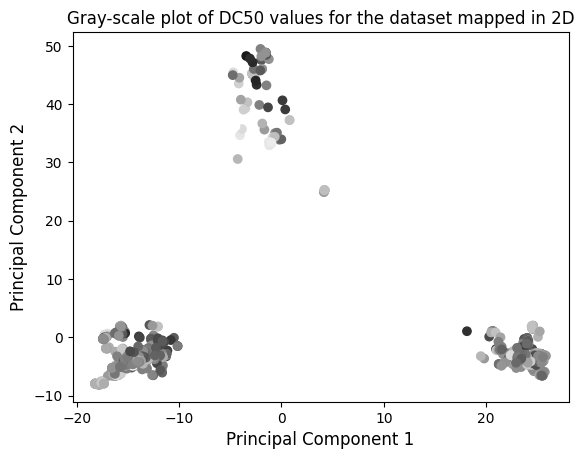

In [41]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# standardise data
scaler = StandardScaler(with_mean=True, with_std=True)
standardised_dataset = scaler.fit_transform(dataset)

# PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(standardised_dataset)
print(X_reduced.shape)

plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap='gray')
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.title("Gray-scale plot of DC50 values for the dataset mapped in 2D")
plt.show()

In [42]:
from sklearn.cluster import KMeans

OMP_NUM_THREADS = 4

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_reduced)

cluster_0_indices = []
cluster_1_indices = []
cluster_2_indices = []

for i, k in enumerate(kmeans.labels_):
    if k == 0:
        cluster_0_indices.append(i)
    elif k == 1:
        cluster_1_indices.append(i)
    else:
        cluster_2_indices.append(i)
        
warheads_1 = warheads[cluster_0_indices]
warheads_2 = warheads[cluster_1_indices]
warheads_3 = warheads[cluster_2_indices]
linkers_1 = linkers[cluster_0_indices]
linkers_2 = linkers[cluster_1_indices]
linkers_3 = linkers[cluster_2_indices]
e3_ligands_1 = e3_ligands[cluster_0_indices]
e3_ligands_2 = e3_ligands[cluster_1_indices]
e3_ligands_3 = e3_ligands[cluster_2_indices]

print(warheads_1[10])


OC(=O)C[C@H]1C2=NN=C(N2C3=C(C(=C(S3)C)C)C(=N1)C4=CC=C(C=C4)Cl)C


100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [02:48<00:00,  1.92it/s]


[[1.         1.         1.         ... 0.89550781 0.87402344 0.88378906]
 [1.         1.         1.         ... 0.89550781 0.87402344 0.88378906]
 [1.         1.         1.         ... 0.89550781 0.87402344 0.88378906]
 ...
 [0.89550781 0.89550781 0.89550781 ... 1.         0.92773438 0.875     ]
 [0.87402344 0.87402344 0.87402344 ... 0.92773438 1.         0.86914062]
 [0.88378906 0.88378906 0.88378906 ... 0.875      0.86914062 1.        ]]


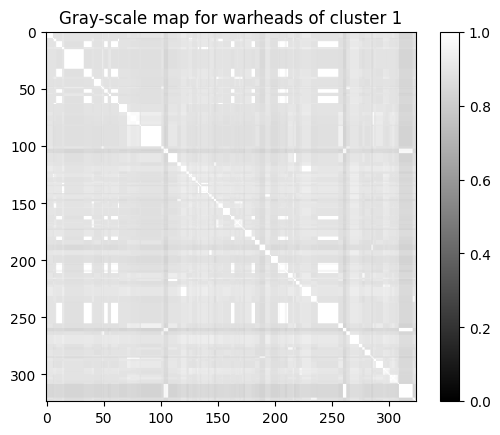

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [06:55<00:00,  1.23it/s]


[[1.         1.         1.         ... 0.88085938 0.89746094 0.89257812]
 [1.         1.         1.         ... 0.88085938 0.89746094 0.89257812]
 [1.         1.         1.         ... 0.88085938 0.89746094 0.89257812]
 ...
 [0.88085938 0.88085938 0.88085938 ... 1.         0.89160156 0.88476562]
 [0.89746094 0.89746094 0.89746094 ... 0.89160156 1.         0.90332031]
 [0.89257812 0.89257812 0.89257812 ... 0.88476562 0.90332031 1.        ]]


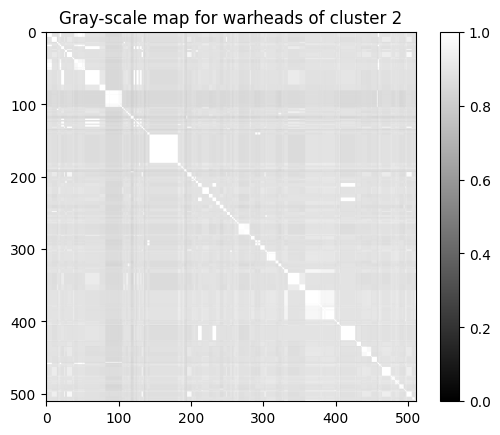

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:07<00:00,  8.87it/s]


[[1.         0.89257812 0.87695312 ... 1.         1.         1.        ]
 [0.89257812 1.         0.86328125 ... 0.89257812 0.89257812 0.89257812]
 [0.87695312 0.86328125 1.         ... 0.87695312 0.87695312 0.87695312]
 ...
 [1.         0.89257812 0.87695312 ... 1.         1.         1.        ]
 [1.         0.89257812 0.87695312 ... 1.         1.         1.        ]
 [1.         0.89257812 0.87695312 ... 1.         1.         1.        ]]


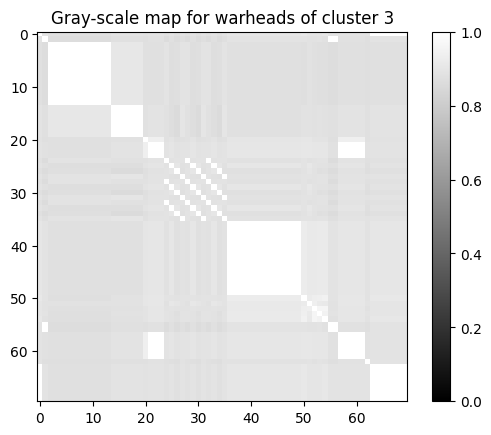

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [01:22<00:00,  3.92it/s]


[[1.         0.98730469 0.98730469 ... 0.96582031 0.98144531 0.97949219]
 [0.98730469 1.         1.         ... 0.9765625  0.98632812 0.9765625 ]
 [0.98730469 1.         1.         ... 0.9765625  0.98632812 0.9765625 ]
 ...
 [0.96582031 0.9765625  0.9765625  ... 1.         0.97070312 0.95703125]
 [0.98144531 0.98632812 0.98632812 ... 0.97070312 1.         0.97265625]
 [0.97949219 0.9765625  0.9765625  ... 0.95703125 0.97265625 1.        ]]


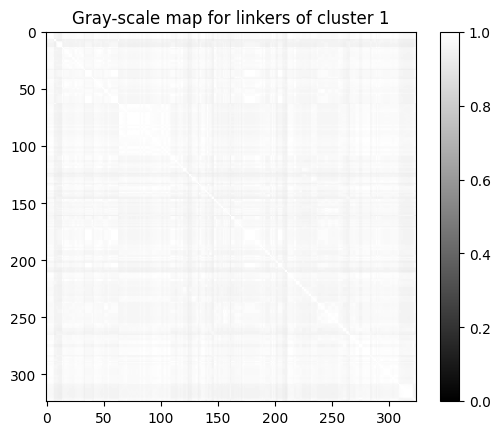

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [03:50<00:00,  2.22it/s]


[[1.         0.98144531 0.9765625  ... 0.96875    0.94726562 0.94726562]
 [0.98144531 1.         0.99121094 ... 0.95800781 0.93652344 0.93652344]
 [0.9765625  0.99121094 1.         ... 0.953125   0.93359375 0.93359375]
 ...
 [0.96875    0.95800781 0.953125   ... 1.         0.96875    0.96875   ]
 [0.94726562 0.93652344 0.93359375 ... 0.96875    1.         1.        ]
 [0.94726562 0.93652344 0.93359375 ... 0.96875    1.         1.        ]]


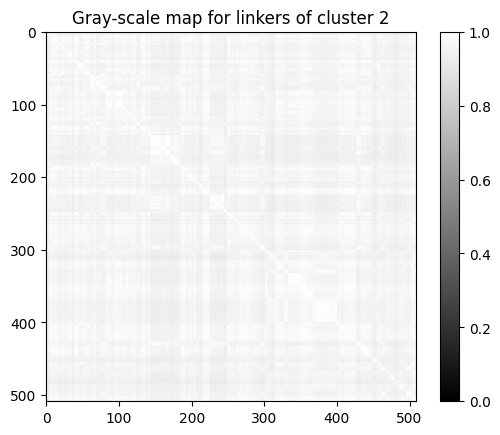

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:04<00:00, 16.52it/s]


[[1.         0.98632812 0.97167969 ... 0.984375   0.984375   0.984375  ]
 [0.98632812 1.         0.96582031 ... 0.97265625 0.97265625 0.97265625]
 [0.97167969 0.96582031 1.         ... 0.95800781 0.95800781 0.95800781]
 ...
 [0.984375   0.97265625 0.95800781 ... 1.         1.         1.        ]
 [0.984375   0.97265625 0.95800781 ... 1.         1.         1.        ]
 [0.984375   0.97265625 0.95800781 ... 1.         1.         1.        ]]


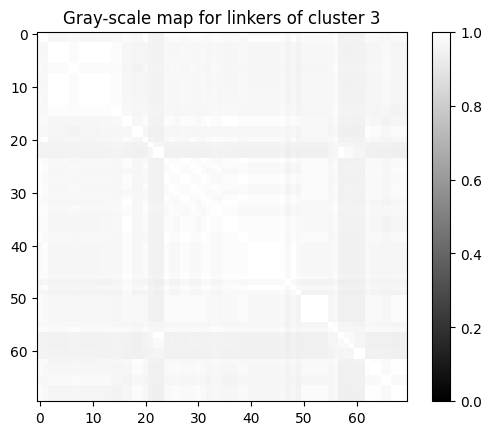

100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [02:44<00:00,  1.97it/s]


[[1.         1.         1.         ... 0.95214844 0.94042969 0.95214844]
 [1.         1.         1.         ... 0.95214844 0.94042969 0.95214844]
 [1.         1.         1.         ... 0.95214844 0.94042969 0.95214844]
 ...
 [0.95214844 0.95214844 0.95214844 ... 1.         0.96875    1.        ]
 [0.94042969 0.94042969 0.94042969 ... 0.96875    1.         0.96875   ]
 [0.95214844 0.95214844 0.95214844 ... 1.         0.96875    1.        ]]


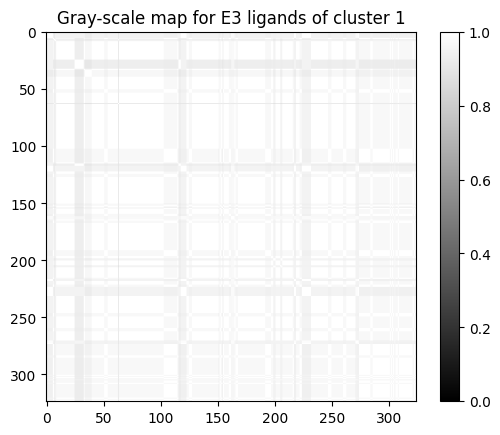

100%|████████████████████████████████████████████████████████████████████████████████| 511/511 [05:05<00:00,  1.67it/s]


[[1.         1.         1.         ... 0.97753906 0.97460938 0.97949219]
 [1.         1.         1.         ... 0.97753906 0.97460938 0.97949219]
 [1.         1.         1.         ... 0.97753906 0.97460938 0.97949219]
 ...
 [0.97753906 0.97753906 0.97753906 ... 1.         0.96386719 0.96289062]
 [0.97460938 0.97460938 0.97460938 ... 0.96386719 1.         0.95800781]
 [0.97949219 0.97949219 0.97949219 ... 0.96289062 0.95800781 1.        ]]


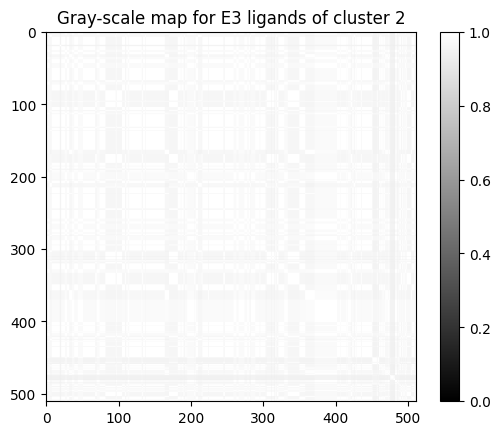

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:07<00:00,  8.93it/s]


[[1.         0.85839844 0.87988281 ... 0.88183594 0.88183594 0.88183594]
 [0.85839844 1.         0.90234375 ... 0.88476562 0.88476562 0.88476562]
 [0.87988281 0.90234375 1.         ... 0.9140625  0.9140625  0.9140625 ]
 ...
 [0.88183594 0.88476562 0.9140625  ... 1.         1.         1.        ]
 [0.88183594 0.88476562 0.9140625  ... 1.         1.         1.        ]
 [0.88183594 0.88476562 0.9140625  ... 1.         1.         1.        ]]


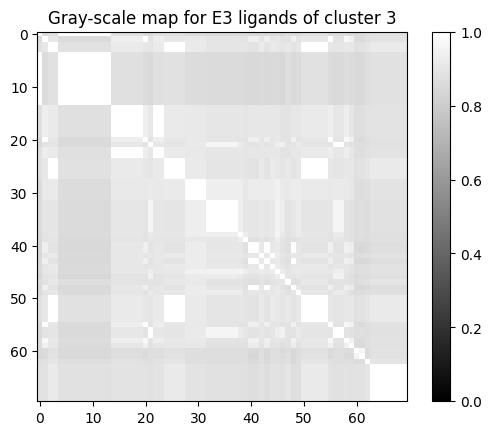

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [21:49<00:00,  1.45s/it]


[[1.         1.         1.         ... 0.88964844 0.8984375  0.88964844]
 [1.         1.         1.         ... 0.88964844 0.8984375  0.88964844]
 [1.         1.         1.         ... 0.88964844 0.8984375  0.88964844]
 ...
 [0.88964844 0.88964844 0.88964844 ... 1.         0.89746094 0.89257812]
 [0.8984375  0.8984375  0.8984375  ... 0.89746094 1.         0.90332031]
 [0.88964844 0.88964844 0.88964844 ... 0.89257812 0.90332031 1.        ]]


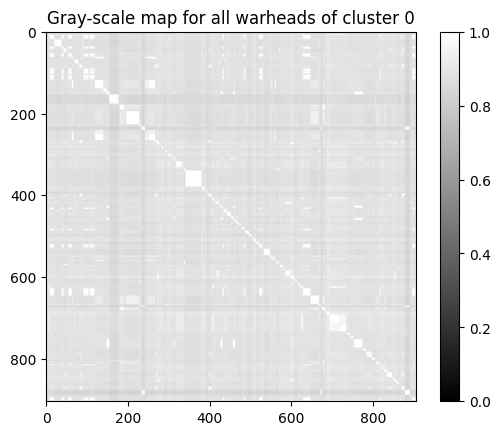

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [11:05<00:00,  1.36it/s]


[[1.         0.98730469 0.98730469 ... 0.96972656 0.96386719 0.96386719]
 [0.98730469 1.         1.         ... 0.96679688 0.96679688 0.96679688]
 [0.98730469 1.         1.         ... 0.96679688 0.96679688 0.96679688]
 ...
 [0.96972656 0.96679688 0.96679688 ... 1.         0.9453125  0.9453125 ]
 [0.96386719 0.96679688 0.96679688 ... 0.9453125  1.         1.        ]
 [0.96386719 0.96679688 0.96679688 ... 0.9453125  1.         1.        ]]


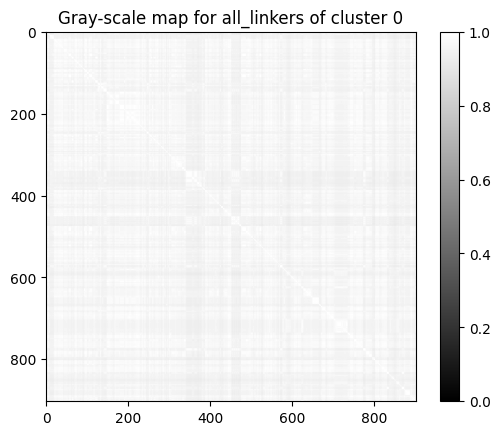

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [15:37<00:00,  1.04s/it]


[[1.         1.         1.         ... 0.87695312 0.88769531 0.890625  ]
 [1.         1.         1.         ... 0.87695312 0.88769531 0.890625  ]
 [1.         1.         1.         ... 0.87695312 0.88769531 0.890625  ]
 ...
 [0.87695312 0.87695312 0.87695312 ... 1.         0.91503906 0.9140625 ]
 [0.88769531 0.88769531 0.88769531 ... 0.91503906 1.         0.95800781]
 [0.890625   0.890625   0.890625   ... 0.9140625  0.95800781 1.        ]]


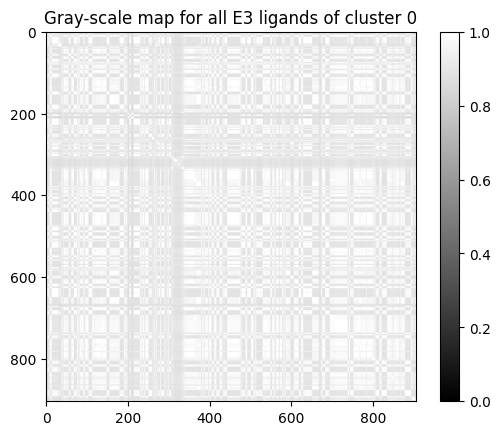

In [43]:
from tqdm import tqdm as tqdm

# Calculate similarity
def calculate_similarity(group, name, cluster_no):
    all_sims = []
    for w in tqdm(group):
        if w == "nan":
            continue
        if "[R2]" in w:
            w = w.replace("[R2]", "")
        current_warhead = get_fingerprint(w)
        sims = []
        for i in range(len(group)):
            if group[i] == "nan":
                continue
            if "[R2]" in group[i]:
                group[i] = group[i].replace("[R2]", "")
            to_compare = get_fingerprint(group[i])
            common = 0
            for bit1, bit2 in zip(current_warhead, to_compare):
                if bit1 == bit2:
                    common += 1
            sim = common/1024
            sims.append(sim)
        sims = np.array(sims)
        all_sims.append(sims)
    all_sims = np.array(all_sims) 
    print(all_sims)
    plt.imshow(all_sims,cmap='gray', vmin=0.0, vmax=1.0)
    s = "Gray-scale map for " + name + " of cluster " + (str (cluster_no)) 
    plt.title(s)
    plt.colorbar()
    plt.show()
    
calculate_similarity(warheads_1, "warheads", 1)
calculate_similarity(warheads_2, "warheads", 2)
calculate_similarity(warheads_3, "warheads", 3)

calculate_similarity(linkers_1, "linkers", 1)
calculate_similarity(linkers_2, "linkers", 2)
calculate_similarity(linkers_3, "linkers", 3)

calculate_similarity(e3_ligands_1, "E3 ligands", 1)
calculate_similarity(e3_ligands_2, "E3 ligands", 2)
calculate_similarity(e3_ligands_3, "E3 ligands", 3)

calculate_similarity(warheads, "all warheads", 0)
calculate_similarity(linkers, "all_linkers", 0)
calculate_similarity(e3_ligands, "all E3 ligands", 0)

In [44]:
new_df = pd.read_csv("protac.csv")
e3_ligases = np.array(new_df["E3 ligase"])
protein_targets = np.array(new_df["Target"])
cluster_0_e3_ligases = set(e3_ligases[cluster_0_indices])
cluster_1_e3_ligases = set(e3_ligases[cluster_1_indices])
cluster_2_e3_ligases = set(e3_ligases[cluster_2_indices])
cluster_0_protein_targets = set(protein_targets[cluster_0_indices])
cluster_1_protein_targets = set(protein_targets[cluster_1_indices])
cluster_2_protein_targets = set(protein_targets[cluster_2_indices])

print("***CLUSTER 1 E3 LIGASES AND PROTEIN TARGETS***")
for c0 in cluster_0_e3_ligases:
    print(c0)
    
for p0 in cluster_0_protein_targets:
    print(p0)
    
print()
print("***CLUSTER 2 E3 LIGASES***")
for c1 in cluster_1_e3_ligases:
    print(c1)
    
for p1 in cluster_1_protein_targets:
    print(p1)
  
print()
print("***CLUSTER 3 E3 LIGASES***")
for c2 in cluster_2_e3_ligases:
    print(c2)
    
for p2 in cluster_2_e3_ligases:
    print(p2)

***CLUSTER 1 E3 LIGASES AND PROTEIN TARGETS***
CRBN
DCAF15
VHL
MDM2
AR
EGFR e19d
BRD7
CDK4
BRD2
ALK
BCL6
MEK2
BRD9
EGFR
STAT3
EGFR L858R
PCAF
FAK
ERRalpha
SIRT2
AURKA
FER
BCR-ABL
p38alpha
BCL2
RIPK2
CDK9
GCN5
BTK C481S
RPS6KA1
BRD3
BRD4
BRD4 BD1
ER
MDM2
c-Met
FKBP12
PARP1
CRBN
CDK2
p38delta
MCL1
CDK6
BTK
MEK1

***CLUSTER 2 E3 LIGASES***
VHL
cIAP1
MDM2
CRBN
DCAF15
AR
EGFR e19d
BRD7
CDK4
BRD2
ALK
FLT3
BRD2 BD2
COQ8A
ALK G1202R
BRD9
EGFR
STAT3
Wee1
EGFR L858R
BRAF
FAK
AURKA
PDK1
BCKDK
FER
PI3Kalpha
BCR-ABL
p38alpha
BCL2
RIPK2
CDK9
BRD3 BD1
BTK C481S
RPS6KA1
BRD3
MerTK
BRD4
PDK3
BRD4 BD1
ER
EGFR L858R/T790M
HER2
MDM2
c-Met
PARP1
CRBN
HDAC6
PDK2
p38delta
MCL1
CDK6
CDK2
BTK
MEK1

***CLUSTER 3 E3 LIGASES***
CRBN
MDM2
VHL
CRBN
MDM2
VHL


100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [07:52<00:00,  1.92it/s]


[[1.         1.         1.         ... 0.88964844 0.88964844 0.88964844]
 [1.         1.         1.         ... 0.88964844 0.88964844 0.88964844]
 [1.         1.         1.         ... 0.88964844 0.88964844 0.88964844]
 ...
 [0.88964844 0.88964844 0.88964844 ... 1.         1.         1.        ]
 [0.88964844 0.88964844 0.88964844 ... 1.         1.         1.        ]
 [0.88964844 0.88964844 0.88964844 ... 1.         1.         1.        ]]


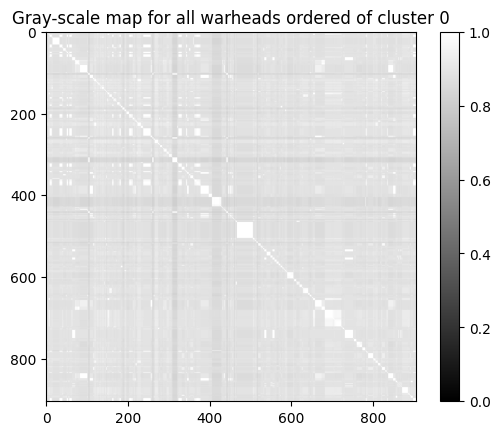

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [04:27<00:00,  3.39it/s]


[[1.         0.98730469 0.98730469 ... 0.96972656 0.96972656 0.96972656]
 [0.98730469 1.         1.         ... 0.96679688 0.96679688 0.96679688]
 [0.98730469 1.         1.         ... 0.96679688 0.96679688 0.96679688]
 ...
 [0.96972656 0.96679688 0.96679688 ... 1.         1.         1.        ]
 [0.96972656 0.96679688 0.96679688 ... 1.         1.         1.        ]
 [0.96972656 0.96679688 0.96679688 ... 1.         1.         1.        ]]


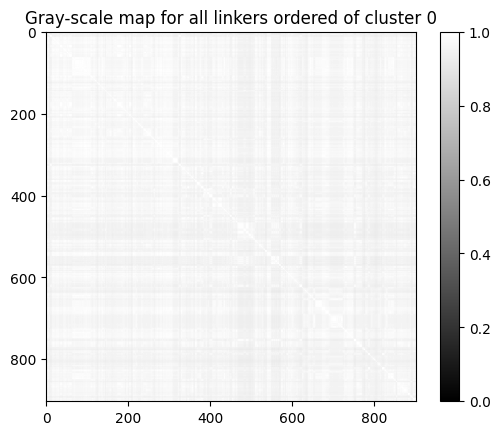

100%|████████████████████████████████████████████████████████████████████████████████| 905/905 [07:29<00:00,  2.01it/s]


[[1.         1.         1.         ... 0.87695312 0.87695312 0.87695312]
 [1.         1.         1.         ... 0.87695312 0.87695312 0.87695312]
 [1.         1.         1.         ... 0.87695312 0.87695312 0.87695312]
 ...
 [0.87695312 0.87695312 0.87695312 ... 1.         1.         1.        ]
 [0.87695312 0.87695312 0.87695312 ... 1.         1.         1.        ]
 [0.87695312 0.87695312 0.87695312 ... 1.         1.         1.        ]]


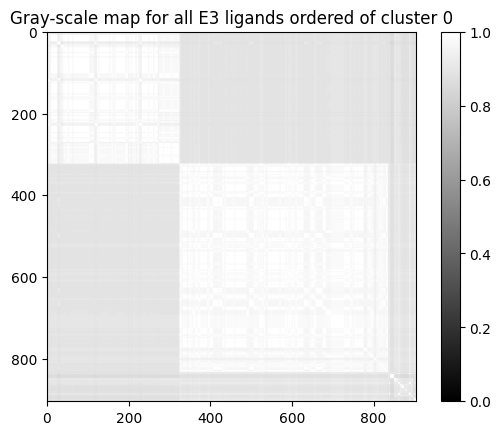

In [47]:
ordered_warheads = np.concatenate((warheads_1, warheads_2, warheads_3))
ordered_linkers = np.concatenate((linkers_1, linkers_2, linkers_3))
ordered_e3_ligands = np.concatenate((e3_ligands_1, e3_ligands_2, e3_ligands_3))

calculate_similarity(ordered_warheads, "all warheads ordered", 0)
calculate_similarity(ordered_linkers, "all linkers ordered", 0)
calculate_similarity(ordered_e3_ligands, "all E3 ligands ordered", 0)